In [1]:
import pandas as pd
import numpy as np

x_train = pd.read_csv('./train_final.csv', engine='python')
x_test = pd.read_csv('./test_final.csv', engine='python')

# y_train = pd.read_csv('./cardashians/ytrain.csv', engine='python')
# y_test = pd.read_csv('./cardashians/ytest.csv', engine='python')

In [2]:
TRAIN_IDX=x_train.shape[0]
TEST_IDX = TRAIN_IDX + x_test.shape[0]

In [3]:
label = 'loan_status'

In [4]:
# x = pd.concat([x_train, x_test], axis=0)
# y = pd.concat([y_train, y_test], axis=0)

# data = pd.concat([x, y], axis=1)
data = pd.concat([x_train, x_test], axis=0)

In [5]:
TRAIN_IDX
TEST_IDX

50000

100000

In [7]:
data.columns.to_list()

['continuous_annual_inc',
 'continuous_annual_inc_joint',
 'continuous_delinq_2yrs',
 'continuous_dti',
 'continuous_dti_joint',
 'continuous_fico_range_high',
 'continuous_fico_range_low',
 'continuous_funded_amnt',
 'continuous_funded_amnt_inv',
 'continuous_inq_last_6mths',
 'continuous_installment',
 'continuous_int_rate',
 'continuous_last_fico_range_high',
 'continuous_last_fico_range_low',
 'continuous_loan_amnt',
 'loan_status',
 'continuous_mths_since_last_delinq',
 'continuous_mths_since_last_major_derog',
 'continuous_mths_since_last_record',
 'continuous_open_acc',
 'continuous_pub_rec',
 'discrete_addr_state_1_one_hot',
 'discrete_addr_state_2_one_hot',
 'discrete_addr_state_3_one_hot',
 'discrete_addr_state_4_one_hot',
 'discrete_addr_state_5_one_hot',
 'discrete_addr_state_6_one_hot',
 'discrete_addr_state_7_one_hot',
 'discrete_addr_state_8_one_hot',
 'discrete_addr_state_9_one_hot',
 'discrete_addr_state_10_one_hot',
 'discrete_addr_state_11_one_hot',
 'discrete_addr_s

## TreeBased Models  

---
In this example, we use lightgbm as the tree model of choice.

In [8]:
train = data.iloc[:TRAIN_IDX, :]
test = data.iloc[TRAIN_IDX:TEST_IDX, :]

In [9]:
import lightgbm as lgb
train_dataset = lgb.Dataset(train.drop(columns=label), train[label])
test_dataset = lgb.Dataset(test.drop(columns=label), test[label])

In [10]:
param = {'num_leaves': 31, 'objective': 'binary', 'metric':'binary_error'}
# param = {'num_leaves': 31, 'objective': 'binary', 'metric':'auc'}
num_round = 2000

In [11]:
model = lgb.train(param, train_dataset, num_boost_round=num_round, valid_sets=[train_dataset, test_dataset], verbose_eval=200,early_stopping_rounds=200)

[LightGBM] [Info] Number of positive: 39788, number of negative: 10212
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2611
[LightGBM] [Info] Number of data points in the train set: 50000, number of used features: 141
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.795760 -> initscore=1.360002
[LightGBM] [Info] Start training from score 1.360002
Training until validation scores don't improve for 200 rounds
[200]	training's binary_error: 0.05664	valid_1's binary_error: 0.08344
Early stopping, best iteration is:
[73]	training's binary_error: 0.06994	valid_1's binary_error: 0.08258


In [12]:
train.shape

(50000, 146)

,Value,Feature
0,345,continuous_last_fico_range_high
1,223,continuous_dti
2,171,continuous_installment
3,138,loan_status
4,125,continuous_fico_range_high


<Figure size 1080x576 with 0 Axes>

<AxesSubplot:xlabel='Value', ylabel='Feature'>

Text(0.5, 1.0, 'LightGBM Features (avg over folds)')

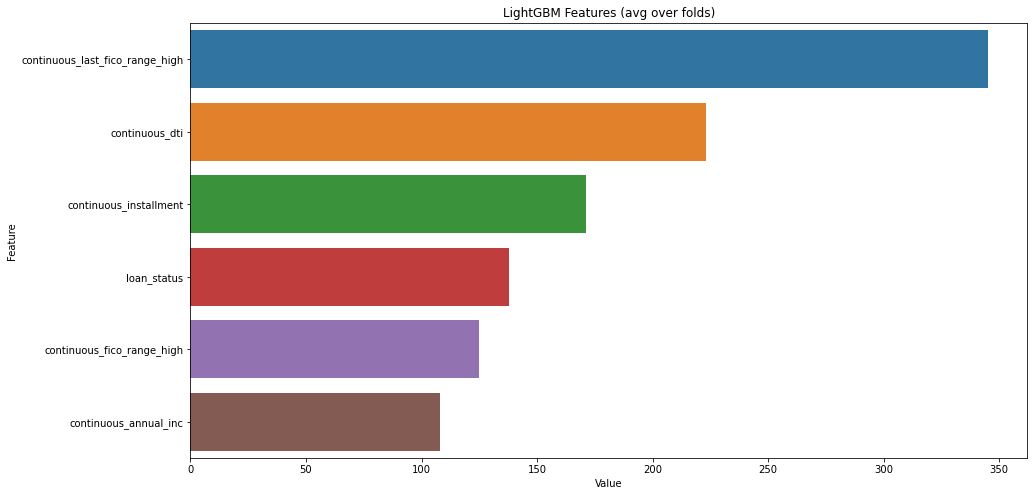

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(model.feature_importance(), train.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), train.columns), reverse=True), columns=['Value','Feature']).head(6)
feature_imp.head()
plt.figure(figsize=(15, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
# plt.tight_layout()
plt.show()

## Wrapper

In [62]:
import io
import multiprocessing
from contextlib import redirect_stdout
from copy import deepcopy
from dataclasses import dataclass, asdict
import hyperopt.pyll
from hyperopt import fmin, tpe, hp
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import torch
import copy

cpu_count = 4
use_gpu = False

In [63]:
@dataclass
class LGBOpt:
    num_threads: any = hp.choice('num_threads', [cpu_count])
    num_leaves: any = hp.choice('num_leaves', [64])
    metric: any = hp.choice('metric', ['binary_error'])
    num_round: any = hp.choice('num_rounds', [1000])
    objective: any = hp.choice('objective', ['binary'])
    learning_rate: any = hp.uniform('learning_rate', 0.01, 0.1)
    feature_fraction: any = hp.uniform('feature_fraction', 0.5, 1.0)
    bagging_fraction: any = hp.uniform('bagging_fraction', 0.8, 1.0)
    device_type: any = hp.choice('device_tpye', ['gpu']) if use_gpu else hp.choice('device_type',
                                                                                   ['cpu'])
#     boosting: any = hp.choice('boosting', ['gbdt', 'dart', 'goss'])
    boosting: any = hp.choice('boosting', ['gbdt', ])
    extra_trees: any = hp.choice('extra_tress', [False, True])
    drop_rate: any = hp.uniform('drop_rate', 0, 0.2)
    uniform_drop: any = hp.choice('uniform_drop', [True, False])
    lambda_l1: any = hp.uniform('lambda_l1', 0, 10)  # TODO: Check range
    lambda_l2: any = hp.uniform('lambda_l2', 0, 10)  # TODO: Check range
    min_gain_to_split: any = hp.uniform('min_gain_to_split', 0, 1)  # TODO: Check range
    min_data_in_bin = hp.choice('min_data_in_bin', [3, 5, 10, 15, 20, 50])

    @staticmethod
    def get_common_params():
        return {'num_thread': 4, 'num_leaves': 12, 'metric': 'binary', 'objective': 'binary',
                'num_round': 1000, 'learning_rate': 0.01, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
    

In [64]:
class FitterBase(object):
    def __init__(self, label, metric, max_eval=100, opt=None):
        self.label = label
        self.metric = metric
        self.opt_params = dict()
        self.max_eval = max_eval
        self.opt = opt

    def get_loss(self, y, y_pred):
        if self.metric == 'error':
            return 1 - accuracy_score(y, y_pred)
        elif self.metric == 'precision':
            return 1 - precision_score(y, y_pred)
        elif self.metric == 'recall':
            return 1 - recall_score(y, y_pred)
        elif self.metric == 'macro_f1':
            return 1 - f1_score(y, y_pred, average='macro')
        elif self.metric == 'micro_f1':
            return 1 - f1_score(y, y_pred, average='micro')
        elif self.metric == 'auc':  # TODO: Add a warning checking if y_predict is all [0, 1], it should be probability
            return roc_auc_score(y, y_pred)
        else:
            raise Exception("Not implemented yet.")


In [65]:
class LGBFitter(FitterBase):
    def __init__(self, label='label', metric='error', opt: LGBOpt = None, max_eval=100):
        super(LGBFitter, self).__init__(label, metric, max_eval)
        if opt is not None:
            self.opt = opt
        else:
            self.opt = LGBOpt()
        self.best_round = None
        self.clf = None

    def train(self, train_df, eval_df, params=None, use_best_eval=True):
        self.best_round = None
        dtrain = lgb.Dataset(train_df.drop(columns=[self.label]), train_df[self.label])
        deval = lgb.Dataset(eval_df.drop(columns=[self.label]), eval_df[self.label])
        evallist = [dtrain, deval]
        if params is None:
            use_params = deepcopy(self.opt_params)
        else:
            use_params = deepcopy(params)

        num_round = use_params.pop('num_round')
        if use_best_eval:
            with io.StringIO() as buf, redirect_stdout(buf):
                self.clf = lgb.train(use_params, dtrain, num_round, valid_sets=evallist)
                output = buf.getvalue().split("\n")
            min_error = np.inf
            min_index = 0
            for idx in range(len(output) - 1):
                if len(output[idx].split("\t")) == 3:
                    temp = float(output[idx].split("\t")[2].split(":")[1])
                    if min_error > temp:
                        min_error = temp
                        min_index = int(output[idx].split("\t")[0][1:-1])
            print("The minimum is attained in round %d" % (min_index + 1))
            self.best_round = min_index + 1
            return output
        else:
            with io.StringIO() as buf, redirect_stdout(buf):
                self.clf = lgb.train(use_params, dtrain, num_round, valid_sets=evallist)
                output = buf.getvalue().split("\n")
            self.best_round = num_round
            return output

    def search(self, train_df, eval_df, use_best_eval=True):
        self.opt_params = dict()

        def train_impl(params):
            self.train(train_df, eval_df, params, use_best_eval)
            if self.metric == 'auc':
                y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
            else:
                y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                           num_iteration=self.best_round) > 0.5).astype(int)
            return self.get_loss(eval_df[self.label], y_pred)

        self.opt_params = fmin(train_impl, asdict(self.opt), algo=tpe.suggest, max_evals=self.max_eval)

    def search_k_fold(self, k_fold, data, use_best_eval=True):
        self.opt_params = dict()

        def train_impl_nfold(params):
            loss = list()
            for train_id, eval_id in k_fold.split(data):
                train_df = data.loc[train_id]
                eval_df = data.loc[eval_id]
                self.train(train_df, eval_df, params, use_best_eval)
                if self.metric == 'auc':
                    y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
                else:
                    y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                               num_iteration=self.best_round) > 0.5).astype(int)
                loss.append(self.get_loss(eval_df[self.label], y_pred))
            return np.mean(loss)

        self.opt_params = fmin(train_impl_nfold, asdict(self.opt), algo=tpe.suggest, max_evals=self.max_eval)

    def train_k_fold(self, k_fold, train_data, test_data, params=None, drop_test_y=True, use_best_eval=True):
        acc_result = list()
        train_pred = np.empty(train_data.shape[0])
        test_pred = np.empty(test_data.shape[0])
        if drop_test_y:
            dtest = test_data.drop(columns=self.label)
        else:
            dtest = test_data

        models = list()
        for train_id, eval_id in k_fold.split(train_data):
            train_df = train_data.loc[train_id]
            eval_df = train_data.loc[eval_id]
            self.train(train_df, eval_df, params, use_best_eval)
            models.append(copy.deepcopy(self.clf))
            train_pred[eval_id] = self.clf.predict(eval_df.drop(columns=self.label), num_iteration=self.best_round)
            if self.metric == 'auc':
                y_pred = self.clf.predict(eval_df.drop(columns=[self.label]), num_iteration=self.best_round)
            else:
                y_pred = (self.clf.predict(eval_df.drop(columns=[self.label]),
                                           num_iteration=self.best_round) > 0.5).astype(int)
            acc_result.append(self.get_loss(eval_df[self.label], y_pred))
            test_pred += self.clf.predict(dtest, num_iteration=self.best_round)
        test_pred /= k_fold.n_splits
        return train_pred, test_pred, acc_result, models

In [66]:
fitter = LGBFitter(label=label)#, metric='error')

In [78]:
from sklearn.utils import shuffle
train = shuffle(train, random_state=42)
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, random_state=42)

In [68]:
params = {'num_thread': 4, 'num_leaves': 12, 'metric': 'binary', 'objective': 'binary', 
          'num_round': 1000, 'learning_rate': 0.02, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}

In [79]:
params = {'num_thread': 4, 'num_leaves': 12, 'metric': 'binary', 'objective': 'binary', 
          'num_round': 1000, 'learning_rate': 0.02, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
train_pred, test_pred, acc_result, models = fitter.train_k_fold(kfold, train, test, params = params)
train_pred
test_pred
acc_result
np.mean(acc_result)

The minimum is attained in round 421
Finished loading model, total used 1000 iterations
The minimum is attained in round 428
Finished loading model, total used 1000 iterations
The minimum is attained in round 399
Finished loading model, total used 1000 iterations
The minimum is attained in round 610
Finished loading model, total used 1000 iterations
The minimum is attained in round 297
Finished loading model, total used 1000 iterations


array([0.57132392, 0.98764479, 0.98316766, ..., 0.98795254, 0.99730327,
       0.99436857])

array([0.93694583, 0.99704801, 0.98051551, ..., 0.97393458, 0.99425868,
       0.99430746])

[0.07230000000000003,
 0.08079999999999998,
 0.08340000000000003,
 0.0837,
 0.08020000000000005]

0.08008000000000001

In [89]:
params = {'num_thread': 4, 'num_leaves': 12, 'metric': 'binary', 'objective': 'binary', 
          'num_round': 500, 'learning_rate': 0.04, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
train_pred, test_pred, acc_result, models = fitter.train_k_fold(kfold, train, test, params = params)
train_pred
test_pred
acc_result
np.mean(acc_result)

The minimum is attained in round 235
Finished loading model, total used 500 iterations
The minimum is attained in round 289
Finished loading model, total used 500 iterations
The minimum is attained in round 297
Finished loading model, total used 500 iterations
The minimum is attained in round 302
Finished loading model, total used 500 iterations
The minimum is attained in round 157
Finished loading model, total used 500 iterations


array([0.54958592, 0.98576335, 0.98489702, ..., 0.9874093 , 0.99753093,
       0.99394327])

array([0.93795266, 0.99728117, 1.22245357, ..., 1.20849751, 1.23303137,
       1.23294966])

[0.07179999999999997,
 0.08109999999999995,
 0.08350000000000002,
 0.08379999999999999,
 0.07989999999999997]

0.08001999999999998

In [88]:
params = {'num_thread': 4, 'num_leaves': 12, 'metric': 'binary', 'objective': 'binary', 
          'num_round': 500, 'learning_rate': 0.04, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
train_pred, test_pred, acc_result, models = fitter.train_k_fold(kfold, train, test, params = params)
train_pred
test_pred
acc_result
np.mean(acc_result)

The minimum is attained in round 235
Finished loading model, total used 500 iterations
The minimum is attained in round 289
Finished loading model, total used 500 iterations
The minimum is attained in round 297
Finished loading model, total used 500 iterations
The minimum is attained in round 302
Finished loading model, total used 500 iterations
The minimum is attained in round 157
Finished loading model, total used 500 iterations


array([0.54958592, 0.98576335, 0.98489702, ..., 0.9874093 , 0.99753093,
       0.99394327])

array([0.93795266, 0.99728117, 1.21448616, ..., 1.20858689, 1.23296505,
       1.23287254])

[0.07179999999999997,
 0.08109999999999995,
 0.08350000000000002,
 0.08379999999999999,
 0.07989999999999997]

0.08001999999999998

In [87]:
for num_lef in [3,6,9,10]:
    params = {'num_thread': 4, 'num_leaves': num_lef, 'metric': 'binary', 'objective': 'binary', 
          'num_round': 500, 'learning_rate': 0.04, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
    train_pred, test_pred, acc_result, models = fitter.train_k_fold(kfold, train, test, params = params)
    train_pred
    test_pred
    acc_result
    np.mean(acc_result)

    print("*"*100)

The minimum is attained in round 501
Finished loading model, total used 500 iterations
The minimum is attained in round 499
Finished loading model, total used 500 iterations
The minimum is attained in round 501
Finished loading model, total used 500 iterations
The minimum is attained in round 480
Finished loading model, total used 500 iterations
The minimum is attained in round 501
Finished loading model, total used 500 iterations


array([0.56112737, 0.9827208 , 0.98366057, ..., 0.9886635 , 0.99846479,
       0.99540066])

array([ 0.92334753,  0.9971198 ,  1.18060263, ..., 16.92098154,
       17.88763764,  0.99313578])

[0.07140000000000002, 0.08020000000000005, 0.08230000000000004, 0.0847, 0.0797]

0.07966000000000002

****************************************************************************************************
The minimum is attained in round 269
Finished loading model, total used 500 iterations
The minimum is attained in round 500
Finished loading model, total used 500 iterations
The minimum is attained in round 320
Finished loading model, total used 500 iterations
The minimum is attained in round 272
Finished loading model, total used 500 iterations
The minimum is attained in round 255
Finished loading model, total used 500 iterations


array([0.55816596, 0.98366786, 0.9863372 , ..., 0.9881421 , 0.99800504,
       0.99562633])

array([0.92432526, 0.99727729, 1.17473678, ..., 0.97478211, 0.99405823,
       0.9941607 ])

[0.0726, 0.08040000000000003, 0.08389999999999997, 0.08360000000000001, 0.0796]

0.08002000000000001

****************************************************************************************************
The minimum is attained in round 248
Finished loading model, total used 500 iterations
The minimum is attained in round 244
Finished loading model, total used 500 iterations
The minimum is attained in round 258
Finished loading model, total used 500 iterations
The minimum is attained in round 240
Finished loading model, total used 500 iterations
The minimum is attained in round 171
Finished loading model, total used 500 iterations


array([0.55303001, 0.98257245, 0.98882171, ..., 0.98706028, 0.99730559,
       0.99476441])

array([0.93260237, 0.99703661, 1.17404467, ..., 1.16893986, 1.19268511,
       1.19275146])

[0.07169999999999999,
 0.08089999999999997,
 0.08379999999999999,
 0.08330000000000004,
 0.08040000000000003]

0.08002000000000001

****************************************************************************************************
The minimum is attained in round 260
Finished loading model, total used 500 iterations
The minimum is attained in round 247
Finished loading model, total used 500 iterations
The minimum is attained in round 205
Finished loading model, total used 500 iterations
The minimum is attained in round 326
Finished loading model, total used 500 iterations
The minimum is attained in round 192
Finished loading model, total used 500 iterations


array([0.55789259, 0.98415991, 0.98650139, ..., 0.98767737, 0.9979097 ,
       0.99534171])

array([0.93485928, 0.99724816, 1.21388175, ..., 1.16849294, 1.19301671,
       1.19313705])

[0.07220000000000004,
 0.08089999999999997,
 0.08340000000000003,
 0.08409999999999995,
 0.07899999999999996]

0.07991999999999999

****************************************************************************************************


In [91]:
for i in [0.7,0.8,0.9]:
    for j in [0.7,0.8,0.9]:
        params = {'num_thread': 4, 'num_leaves': 3, 'metric': 'binary', 'objective': 'binary', 
              'num_round': 1000, 'learning_rate': 0.04, 'feature_fraction': i, 'bagging_fraction': j}
        train_pred, test_pred, acc_result, models = fitter.train_k_fold(kfold, train, test, params = params)
        train_pred
        test_pred
        acc_result
        np.mean(acc_result)
        print(i, j)
        print("*"*100)

The minimum is attained in round 797
Finished loading model, total used 1000 iterations
The minimum is attained in round 607
Finished loading model, total used 1000 iterations
The minimum is attained in round 767
Finished loading model, total used 1000 iterations
The minimum is attained in round 940
Finished loading model, total used 1000 iterations
The minimum is attained in round 602
Finished loading model, total used 1000 iterations


array([0.56183917, 0.98275491, 0.98822176, ..., 0.9893255 , 0.99870949,
       0.99582116])

array([0.92580428, 0.99741761, 1.22553151, ..., 1.21673828, 1.24200103,
       1.24173591])

[0.07220000000000004,
 0.08050000000000002,
 0.08309999999999995,
 0.08420000000000005,
 0.07930000000000004]

0.07986000000000001

0.7 0.7
****************************************************************************************************
The minimum is attained in round 797
Finished loading model, total used 1000 iterations
The minimum is attained in round 607
Finished loading model, total used 1000 iterations
The minimum is attained in round 767
Finished loading model, total used 1000 iterations
The minimum is attained in round 940
Finished loading model, total used 1000 iterations
The minimum is attained in round 602
Finished loading model, total used 1000 iterations


array([0.56183917, 0.98275491, 0.98822176, ..., 0.9893255 , 0.99870949,
       0.99582116])

array([0.92580428, 0.99741761, 1.22553648, ..., 1.21672258, 1.24199718,
       1.24173601])

[0.07220000000000004,
 0.08050000000000002,
 0.08309999999999995,
 0.08420000000000005,
 0.07930000000000004]

0.07986000000000001

0.7 0.8
****************************************************************************************************
The minimum is attained in round 797
Finished loading model, total used 1000 iterations
The minimum is attained in round 607
Finished loading model, total used 1000 iterations
The minimum is attained in round 767
Finished loading model, total used 1000 iterations
The minimum is attained in round 940
Finished loading model, total used 1000 iterations
The minimum is attained in round 602
Finished loading model, total used 1000 iterations


array([0.56183917, 0.98275491, 0.98822176, ..., 0.9893255 , 0.99870949,
       0.99582116])

array([0.92580428, 0.99741761, 1.22546505, ..., 1.21717941, 1.24202548,
       1.2418122 ])

[0.07220000000000004,
 0.08050000000000002,
 0.08309999999999995,
 0.08420000000000005,
 0.07930000000000004]

0.07986000000000001

0.7 0.9
****************************************************************************************************
The minimum is attained in round 710
Finished loading model, total used 1000 iterations
The minimum is attained in round 724
Finished loading model, total used 1000 iterations
The minimum is attained in round 817
Finished loading model, total used 1000 iterations
The minimum is attained in round 599
Finished loading model, total used 1000 iterations
The minimum is attained in round 580
Finished loading model, total used 1000 iterations


array([0.56462009, 0.98224674, 0.98748878, ..., 0.98908175, 0.99870961,
       0.99550807])

array([0.92382798, 0.99738348, 1.22522852, ..., 1.21637536, 1.2419896 ,
       1.24178917])

[0.07169999999999999,
 0.07999999999999996,
 0.08289999999999997,
 0.08440000000000003,
 0.0796]

0.07971999999999999

0.8 0.7
****************************************************************************************************
The minimum is attained in round 710
Finished loading model, total used 1000 iterations
The minimum is attained in round 724
Finished loading model, total used 1000 iterations
The minimum is attained in round 817
Finished loading model, total used 1000 iterations
The minimum is attained in round 599
Finished loading model, total used 1000 iterations
The minimum is attained in round 580
Finished loading model, total used 1000 iterations


array([0.56462009, 0.98224674, 0.98748878, ..., 0.98908175, 0.99870961,
       0.99550807])

array([0.92382798, 0.99738348, 1.22521423, ..., 1.21646672, 1.24199526,
       1.24180441])

[0.07169999999999999,
 0.07999999999999996,
 0.08289999999999997,
 0.08440000000000003,
 0.0796]

0.07971999999999999

0.8 0.8
****************************************************************************************************
The minimum is attained in round 710
Finished loading model, total used 1000 iterations
The minimum is attained in round 724
Finished loading model, total used 1000 iterations
The minimum is attained in round 817
Finished loading model, total used 1000 iterations
The minimum is attained in round 599
Finished loading model, total used 1000 iterations
The minimum is attained in round 580
Finished loading model, total used 1000 iterations


array([0.56462009, 0.98224674, 0.98748878, ..., 0.98908175, 0.99870961,
       0.99550807])

array([0.92382798, 0.99738348, 1.22516693, ..., 1.21630591, 1.24198808,
       1.24179981])

[0.07169999999999999,
 0.07999999999999996,
 0.08289999999999997,
 0.08440000000000003,
 0.0796]

0.07971999999999999

0.8 0.9
****************************************************************************************************
The minimum is attained in round 728
Finished loading model, total used 1000 iterations
The minimum is attained in round 683
Finished loading model, total used 1000 iterations
The minimum is attained in round 758
Finished loading model, total used 1000 iterations
The minimum is attained in round 869
Finished loading model, total used 1000 iterations
The minimum is attained in round 592
Finished loading model, total used 1000 iterations


array([0.56552745, 0.98212273, 0.9875707 , ..., 0.98881816, 0.99877782,
       0.99558217])

array([0.92468645, 0.9973403 , 1.22548468, ..., 1.21609859, 1.24188154,
       1.24176756])

[0.07169999999999999,
 0.08020000000000005,
 0.08299999999999996,
 0.08399999999999996,
 0.0797]

0.07971999999999999

0.9 0.7
****************************************************************************************************
The minimum is attained in round 728
Finished loading model, total used 1000 iterations
The minimum is attained in round 683
Finished loading model, total used 1000 iterations
The minimum is attained in round 758
Finished loading model, total used 1000 iterations
The minimum is attained in round 869
Finished loading model, total used 1000 iterations
The minimum is attained in round 592
Finished loading model, total used 1000 iterations


array([0.56552745, 0.98212273, 0.9875707 , ..., 0.98881816, 0.99877782,
       0.99558217])

array([0.92468645, 0.9973403 , 1.22547522, ..., 1.21606643, 1.2418801 ,
       1.24176664])

[0.07169999999999999,
 0.08020000000000005,
 0.08299999999999996,
 0.08399999999999996,
 0.0797]

0.07971999999999999

0.9 0.8
****************************************************************************************************
The minimum is attained in round 728
Finished loading model, total used 1000 iterations
The minimum is attained in round 683
Finished loading model, total used 1000 iterations
The minimum is attained in round 758
Finished loading model, total used 1000 iterations
The minimum is attained in round 869
Finished loading model, total used 1000 iterations
The minimum is attained in round 592
Finished loading model, total used 1000 iterations


array([0.56552745, 0.98212273, 0.9875707 , ..., 0.98881816, 0.99877782,
       0.99558217])

array([0.92468645, 0.9973403 , 1.22553877, ..., 1.21602496, 1.24185879,
       1.24176019])

[0.07169999999999999,
 0.08020000000000005,
 0.08299999999999996,
 0.08399999999999996,
 0.0797]

0.07971999999999999

0.9 0.9
****************************************************************************************************


In [93]:
for lr  in [0.005, 0.01, 0.02]:
    params = {'num_thread': 4, 'num_leaves': 3, 'metric': 'binary', 'objective': 'binary', 
          'num_round': 4000, 'learning_rate': 0.01, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
    train_pred, test_pred, acc_result, models = fitter.train_k_fold(kfold, train, test, params = params)
    train_pred
    test_pred
    acc_result
    np.mean(acc_result)
    print("*"*100)

The minimum is attained in round 3044
Finished loading model, total used 4000 iterations
The minimum is attained in round 2790
Finished loading model, total used 4000 iterations
The minimum is attained in round 3526
Finished loading model, total used 4000 iterations
The minimum is attained in round 3937
Finished loading model, total used 4000 iterations
The minimum is attained in round 2382
Finished loading model, total used 4000 iterations


array([0.56555803, 0.98225181, 0.98749487, ..., 0.98895794, 0.99877657,
       0.99558641])

array([0.92434078, 0.99736012, 0.98038301, ..., 0.97313799, 0.99356038,
       0.99351334])

[0.07220000000000004,
 0.08040000000000003,
 0.08289999999999997,
 0.08399999999999996,
 0.0797]

0.07984

0.9 0.9
****************************************************************************************************


In [95]:
params = {'num_thread': 4, 'num_leaves': 3, 'metric': 'binary', 'objective': 'binary', 
      'num_round':1000, 'learning_rate': 0.04, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
train_pred, test_pred, acc_result, models = fitter.train_k_fold(kfold, train, test, params = params)
train_pred
test_pred
acc_result
np.mean(acc_result)

The minimum is attained in round 710
Finished loading model, total used 1000 iterations
The minimum is attained in round 724
Finished loading model, total used 1000 iterations
The minimum is attained in round 817
Finished loading model, total used 1000 iterations
The minimum is attained in round 599
Finished loading model, total used 1000 iterations
The minimum is attained in round 580
Finished loading model, total used 1000 iterations


array([0.56462009, 0.98224674, 0.98748878, ..., 0.98908175, 0.99870961,
       0.99550807])

array([0.92382798, 0.99738348, 1.17619783, ..., 1.16765844, 1.19230224,
       1.19214464])

[0.07169999999999999,
 0.07999999999999996,
 0.08289999999999997,
 0.08440000000000003,
 0.0796]

0.07971999999999999

In [97]:
params = {'num_thread': 4, 'num_leaves': 3, 'metric': 'binary', 'objective': 'binary', 
          'num_round': 500, 'learning_rate': 0.04, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
train_pred, test_pred, acc_result, models = fitter.train_k_fold(kfold, train, test, params = params)
train_pred
test_pred
acc_result
np.mean(acc_result)

The minimum is attained in round 501
Finished loading model, total used 500 iterations
The minimum is attained in round 499
Finished loading model, total used 500 iterations
The minimum is attained in round 501
Finished loading model, total used 500 iterations
The minimum is attained in round 480
Finished loading model, total used 500 iterations
The minimum is attained in round 501
Finished loading model, total used 500 iterations


array([0.56112737, 0.9827208 , 0.98366057, ..., 0.9886635 , 0.99846479,
       0.99540066])

array([0.92334753, 0.9971198 , 1.22574471, ..., 1.21501884, 1.24203952,
       1.24143335])

[0.07140000000000002, 0.08020000000000005, 0.08230000000000004, 0.0847, 0.0797]

0.07966000000000002

In [98]:
accuracy_score(test[label], (test_pred> 0.5).astype(int))

0.91588